In [1]:
!pip install conllu

In [2]:
!pip install torchtext

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from conllu import parse_incr
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim.downloader
from torch.utils.data import Dataset
from torchtext.vocab import build_vocab_from_iterator, Vocab
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
plt.style.use('ggplot')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
torch.manual_seed(42)

In [5]:
tags = set()
with open('/content/drive/MyDrive/INLP/Assignment - 2/en_atis-ud-train.conllu', 'r', encoding='utf-8') as f:
    for sentence in parse_incr(f):
        for token in sentence:
            # print(f"Word: {token['form']}, POS Tag: {token['upostag']}")
            tags.add(token['upostag'])

In [6]:
tags = list(tags)
tags

['NUM',
 'NOUN',
 'DET',
 'ADJ',
 'CCONJ',
 'PART',
 'ADP',
 'PRON',
 'INTJ',
 'PROPN',
 'ADV',
 'AUX',
 'VERB']

In [7]:
tag_map = {tag: i for i, tag in enumerate(tags)}
# tag_map['PAD'] = len(tag_map)
# tag_map['START'] = len(tag_map)
# tag_map['END'] = len(tag_map)
# tag_map['UNK'] = len(tag_map)
tag_map

{'NUM': 0,
 'NOUN': 1,
 'DET': 2,
 'ADJ': 3,
 'CCONJ': 4,
 'PART': 5,
 'ADP': 6,
 'PRON': 7,
 'INTJ': 8,
 'PROPN': 9,
 'ADV': 10,
 'AUX': 11,
 'VERB': 12}

In [8]:
tag_map = {'VERB': 0,
 'ADJ': 1,
 'DET': 2,
 'ADP': 3,
 'PRON': 4,
 'CCONJ': 5,
 'NUM': 6,
 'INTJ': 7,
 'ADV': 8,
 'AUX': 9,
 'PROPN': 10,
 'NOUN': 11,
 'PART': 12}

In [9]:
def get_data(path):
  data = []
  data_file = open(path, "r", encoding="utf-8")
  for sentence in parse_incr(data_file):
      sent = sentence.metadata
      tok_sent = sent_tokenize(sent['text'])
      words = []
      tags = []
      for token in sentence:
          # print(f"Word: {token['form']}, POS Tag: {token['upostag']}")
          if token['upostag'] != 'SYM':
            words.append(token['form'])
            tags.append(tag_map[token['upostag']])
      data.append((words, tags))
  return data

In [10]:
train_data = get_data("/content/drive/MyDrive/INLP/Assignment - 2/en_atis-ud-train.conllu")
val_data = get_data("/content/drive/MyDrive/INLP/Assignment - 2/en_atis-ud-dev.conllu")
test_data = get_data("/content/drive/MyDrive/INLP/Assignment - 2/en_atis-ud-test.conllu")

In [11]:
def get_sent_tags(data):
  sentences = []
  tags = []
  for d in data:
    sentences.append(d[0])
    tags.append(d[1])
  return sentences, tags

In [12]:
p = 3  # Number of previous tokens
s = 3  # Number of successive tokens

In [13]:
def create_sliding_windows_with_labels(sentences, labels, p, s, tag_map):
    windows = []
    extended_labels = []

    for sentence, label_sequence in zip(sentences, labels):
        # Extend the sentence to handle previous and successive tokens
        extended_sentence = (['<s>'] * p) + sentence + (['</s>'] * s)

        # Extend the label sequence accordingly
        extended_labels_sequence = ([88] * p) + label_sequence + ([99] * s)  # Assuming 0 is the padding label

        # Create sliding windows
        for i in range(len(extended_sentence) - p - s):
            window = extended_sentence[i : i + p + s + 1]
            window_labels = extended_labels_sequence[i : i + p + s + 1]
            label = window_labels[p]

            windows.append((window, label))

    return windows

In [14]:
train_sent, train_tags = get_sent_tags(train_data)
val_sent, val_tags = get_sent_tags(val_data)
test_sent, test_tags = get_sent_tags(test_data)

In [15]:
train_result = create_sliding_windows_with_labels(train_sent, train_tags, p, s, tag_map)
val_result = create_sliding_windows_with_labels(val_sent, val_tags, p, s, tag_map)
test_result = create_sliding_windows_with_labels(test_sent, test_tags, p, s, tag_map)

In [16]:
train_result[0]

(['<s>', '<s>', '<s>', 'what', 'is', 'the', 'cost'], 4)

In [17]:
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


In [18]:
START_TOKEN = "<s>"
END_TOKEN = "</s>"
UNKNOWN_TOKEN = "<unk>"
PAD_TOKEN = "<pad>"

In [19]:
class POSTagDataset(Dataset):
    def __init__(self, data: list[tuple[list[str], int]], num_classes, vocabulary:Vocab|None=None):
        self.sentences = [i[0] for i in data] # list of sentences
        self.labels = [i[1] for i in data]

        # one_hot_vecs = []
        # for label in self.labels:
        #   one_hot = [0] * num_classes
        #   one_hot[label] = 1
        #   one_hot_vecs.append(one_hot)

        # self.labels = one_hot_vecs

        # self.embeddings = []
        # for sentence in self.sentences:
        #     embeds = []
        #     for word in sentence:
        #         embed = glove_vectors[word] if word in glove_vectors.key_to_index else [0.0] * 300
        #         embeds.append(embed)
        #     # sentence_embed = [glove_vectors[word] for word in sentence if word in glove_vectors]
        #     stacked_embeddings = [item for sublist in embeds for item in sublist]
        #     self.embeddings.append(stacked_embeddings)

        # Replace words which occur less than 5 times with <UNK>
        all_words = [word for sentence in self.sentences for word in sentence]

        word_counts = Counter(all_words)
        frequency_threshold = 5

        infrequent_words = {word for word, count in word_counts.items() if count < frequency_threshold}
        sentences_with_unk = [["<unk>" if word in infrequent_words else word for word in sentence]for sentence in self.sentences]

        self.sentences = sentences_with_unk
        # print("length of sentences: ", len(self.sentences))
        # print("length of labels: ", len(self.labels))
        # print("length of embeddings: ", len(self.embeddings))

        if vocabulary is None:
            self.vocabulary = build_vocab_from_iterator(self.sentences, specials=[START_TOKEN, END_TOKEN, UNKNOWN_TOKEN]) # use min_freq for handling unkown words better
            self.vocabulary.set_default_index(self.vocabulary[UNKNOWN_TOKEN])
        else:
            self.vocabulary = vocabulary

    def __len__(self) -> int:
        return len(self.sentences)

    def __getlabels__(self) -> list[int]:
        return self.labels

    def __getembeddings__(self) -> list[list[float]]:
        return self.embeddings

    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        """Get the datapoint at `index`."""
        # return torch.tensor(self.vocabulary.lookup_indices(self.sentences[index])), torch.tensor(self.labels[index])
        return torch.tensor(self.vocabulary.lookup_indices(self.sentences[index])), torch.tensor(self.labels[index])

In [20]:
train_dataset = POSTagDataset(train_result,len(tag_map))
val_dataset = POSTagDataset(val_result,len(tag_map), vocabulary=train_dataset.vocabulary)
test_dataset = POSTagDataset(test_result,len(tag_map), vocabulary=train_dataset.vocabulary)

In [21]:
train_vocab = train_dataset.vocabulary.get_stoi()

In [22]:
import pickle

def save_vocab(vocab, filename):
    with open(filename, 'wb') as file:
        pickle.dump(vocab, file)

In [23]:
import os
os.chdir("/content/drive/MyDrive/INLP/Assignment - 2")
os.getcwd()

'/content/drive/MyDrive/INLP/Assignment - 2'

In [24]:
save_vocab(train_vocab, "ffnn_model2_vocab_ps3.pkl")

In [25]:
num_to_word = {value: key for key, value in train_vocab.items()}
num_to_word

{791: 'supper',
 790: 'sort',
 789: 'snacks',
 787: 'pearson',
 786: 'nw',
 783: 'lester',
 781: 'kinds',
 780: 'inform',
 778: 'discount',
 777: 'companies',
 774: 'bay',
 770: '746',
 769: '730',
 768: '723',
 767: '459',
 765: '417',
 758: '1230',
 756: '1130',
 755: '1045',
 752: 'trans',
 751: 'thereafter',
 747: 'say',
 744: 'off',
 743: 'oak',
 742: 'largest',
 740: 'inexpensive',
 738: 'greatest',
 735: 'connects',
 734: 'called',
 733: 'bound',
 731: 'approximately',
 730: '705',
 728: '1850',
 727: '1055',
 726: "'ve",
 725: 'world',
 717: 'travels',
 716: 'toward',
 715: 'tonight',
 714: 'thing',
 713: 'they',
 737: 'ever',
 711: 'taking',
 707: 'spend',
 706: 'sorry',
 704: 'single',
 703: 'seventeen',
 702: 'seat',
 699: 'run',
 695: 'red',
 694: 'reaching',
 690: 'priced',
 688: 'overnight',
 686: 'operation',
 685: 'offered',
 684: 'nighttime',
 682: 'must',
 680: 'midway',
 678: 'listed',
 676: 'limo',
 763: '324',
 675: 'lga',
 696: 'regarding',
 674: 'lands',
 673: 'l

In [26]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [58]:
# p = 2
# s = 2
input_size = (p + 1 + s) * 300 # 300 is the embedding dim
hidden_size = 128
num_classes = len(tag_map)

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_rate=0.5):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024, 512)
        # self.fc4 = nn.Linear(256, num_classes)
        self.fc4 = nn.Linear(512, 256)
        self.fc = nn.Linear(512, 256)
        self.fc6 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(dropout_rate)
        self.double()

    def forward(self, x):
        x = x.to(torch.double)
        out = self.fc1(x)
        out = self.relu(out)
        # out = self.dropout(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        # out = self.relu(out)
        # out = self.fc6(out)
        # out = self.relu(out)
        # out = self.fc7(out)
        # out = self.relu(out)


        return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

In [59]:
input_size, num_classes

(2100, 13)

In [60]:
loss_fn = torch.nn.CrossEntropyLoss() # use ignore index to ignore losses for padding value indices
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [61]:
from tqdm import tqdm
import torch.nn.functional as F

import copy

In [62]:
# Train the model
num_epochs = 10
total_step = len(train_loader)
count = 0
true_val_labels = []
predicted_val_labels = []

losses = []
accs = []

for epoch in tqdm(range(num_epochs), desc="Epochs"):
    total_correct = 0
    total_samples = 0
    val_accs = []
    val_losses = []
    train_accs = []
    train_losses = []
    for i, (sent, label) in enumerate(train_loader):
        # print("sent: ", sent)
        num_arr = sent.numpy()
        # print("sent after converting: ", sent[0].numpy())
        # print("label: ", label)
        # print("--"*20)
        # Move tensors to the configured device
        # images = images.reshape(-1, 28*28).to(device)

        input_embed = []
        for arr in num_arr:
          embeds = []
          # print("array: ", arr)
          for num in arr:
            word = num_to_word[num]
            # print('word: ', word)
            # if word not in glove_vectors.key_to_index:
              # print(f"{word} not in glove")
            embed = glove_vectors[word] if word in glove_vectors.key_to_index else np.random.uniform(-1.0,1.0,size = (300,))
            # if word == '<s>':
            #   embed = [-1.0]*300
            # elif word == '</s>':
            #   embed = [1.0]*300

            arr = embed.copy()

            # embed /= np.linalg.norm(arr)
            embeds.append(embed)
          embeddings = np.array([item for sublist in embeds for item in sublist])
          # print("sub size: ",embeddings.shape)
          input_embed.append(embeddings)

        input_embed = np.array(input_embed, dtype = np.double)
        input_embed = torch.tensor(input_embed, dtype=torch.double)
        # print("input dtype: ", input_embed.dtype)
        # input_embed = input_embed.to(torch.double)
        # print("input embeddings size: ", input_embed.shape)
        # input_embed = input_embed.to(device)
        input_embed = input_embed.to(device, dtype=torch.double)
        label = label.to(device)

        # # Forward pass

        outputs = model(input_embed)
        # print("outputs size: ", outputs.shape)

        # outputs = torch.argmax(outputs)
        # print("outputs: ", outputs)
        # print("label: ", label)
        # break
        # outputs = nn.Softmax(outputs, dim = 1)
        # print("softmax output: ", outputs)
        loss = loss_fn(outputs, label)

        # # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if (i+1) % 100 == 0:
        #     print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
        #            .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        _, predicted = torch.max(outputs.data, 1)
        total_samples += label.size(0)
        total_correct += (predicted == label).sum().item()
        train_losses.append(loss.item())
        train_accs.append((total_correct / total_samples) * 100)
        # if (i+1) % 100 == 0:
        #     print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.2f}%'
        #           .format(epoch+1, num_epochs, i+1, total_step, loss.item(), (total_correct / total_samples) * 100))

    # if (i+1) % 100 == 0:
    #   print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
    #               .format(epoch+1, num_epochs, loss.item(), (total_correct / total_samples) * 100))

    #---------VAL-----------
    model.eval()
    total_val_correct = 0
    total_val_samples = 0

    for i, (val_sent, val_label) in enumerate(val_loader):
      num_arr = val_sent.numpy()
      input_embed = []
      for arr in num_arr:
        embeds = []
        # print("array: ", arr)
        for num in arr:
          word = num_to_word[num]
          # print('word: ', word)
          # if word not in glove_vectors.key_to_index:
              # print(f"{word} not in glove")
          embed = glove_vectors[word] if word in glove_vectors.key_to_index else np.random.uniform(-1.0,1.0,size = (300,))
          # if word == '<s>':
          #   embed = [-1.0]*300
          # elif word == '</s>':
          #   embed = [1.0]*300

          arr = embed.copy()

          # embed /= np.linalg.norm(arr)
          embeds.append(embed)
        embeddings = np.array([item for sublist in embeds for item in sublist])
        # print("sub size: ",embeddings.shape)
        input_embed.append(embeddings)

      input_embed = np.array(input_embed, dtype = np.double)
      input_embed = torch.tensor(input_embed, dtype=torch.double)
      input_embed = input_embed.to(device, dtype=torch.double)
      val_label = val_label.to(device)

      outputs = model(input_embed)
      val_loss = loss_fn(outputs, val_label)
      _, predicted = torch.max(outputs.data, 1)
      total_val_samples += val_label.size(0)
      total_val_correct += (predicted == val_label).sum().item()

      true_val_labels.extend(val_label.cpu().numpy())
      predicted_val_labels.extend(predicted.cpu().numpy())

      val_accs.append((total_val_correct / total_val_samples) * 100)
      val_losses.append(loss.item())

      # if (i+1) % 100 == 0:
      #       print('Epoch [{}/{}], Step [{}/{}], Val Loss: {:.4f}, Val Accuracy: {:.2f}%'
      #             .format(epoch+1, num_epochs, i+1, total_step, loss.item(), (total_val_correct / total_val_samples) * 100))

    avg_train_accs = np.array(train_accs).mean()
    avg_val_accs = np.array(val_accs).mean()
    avg_train_loss = np.array(train_losses).mean()
    avg_val_loss = np.array(val_losses).mean()

    losses.append(avg_val_loss)
    accs.append(avg_val_accs)

    # if (i+1) % 100 == 0:
    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.2f}%, Val Loss: {:.4f}, Val Accuracy: {:.2f}%'
                  .format(epoch+1, num_epochs, avg_train_loss, avg_train_accs, avg_val_loss, avg_val_accs))

Epochs:  10%|█         | 1/10 [03:02<27:20, 182.32s/it]

Epoch [1/10], Train Loss: 0.2554, Train Accuracy: 86.52%, Val Loss: 0.0014, Val Accuracy: 94.99%


Epochs:  20%|██        | 2/10 [06:02<24:07, 180.97s/it]

Epoch [2/10], Train Loss: 0.1154, Train Accuracy: 96.93%, Val Loss: 0.0488, Val Accuracy: 96.14%


Epochs:  30%|███       | 3/10 [09:14<21:43, 186.28s/it]

Epoch [3/10], Train Loss: 0.0955, Train Accuracy: 97.49%, Val Loss: 0.0040, Val Accuracy: 95.98%


Epochs:  40%|████      | 4/10 [12:37<19:16, 192.74s/it]

Epoch [4/10], Train Loss: 0.0845, Train Accuracy: 97.83%, Val Loss: 0.0019, Val Accuracy: 95.70%


Epochs:  50%|█████     | 5/10 [16:08<16:36, 199.40s/it]

Epoch [5/10], Train Loss: 0.0731, Train Accuracy: 97.99%, Val Loss: 0.0078, Val Accuracy: 96.20%


Epochs:  60%|██████    | 6/10 [19:46<13:42, 205.64s/it]

Epoch [6/10], Train Loss: 0.0686, Train Accuracy: 98.26%, Val Loss: 0.1018, Val Accuracy: 96.53%


Epochs:  70%|███████   | 7/10 [23:26<10:30, 210.31s/it]

Epoch [7/10], Train Loss: 0.0645, Train Accuracy: 98.25%, Val Loss: 0.0000, Val Accuracy: 96.04%


Epochs:  80%|████████  | 8/10 [27:08<07:07, 213.99s/it]

Epoch [8/10], Train Loss: 0.0652, Train Accuracy: 98.45%, Val Loss: 0.0017, Val Accuracy: 96.61%


Epochs:  90%|█████████ | 9/10 [30:55<03:38, 218.21s/it]

Epoch [9/10], Train Loss: 0.0571, Train Accuracy: 98.43%, Val Loss: 0.0352, Val Accuracy: 96.66%


Epochs: 100%|██████████| 10/10 [34:44<00:00, 208.49s/it]

Epoch [10/10], Train Loss: 0.0576, Train Accuracy: 98.57%, Val Loss: 0.0008, Val Accuracy: 96.74%


In [63]:
new_loss = []
for l in losses:
  new_loss.append(l.item())

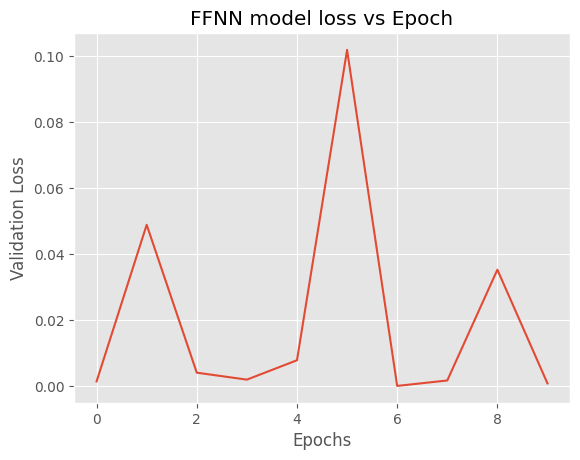

In [64]:
plt.plot(range(len(new_loss)), new_loss)
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("FFNN model loss vs Epoch")
plt.show()

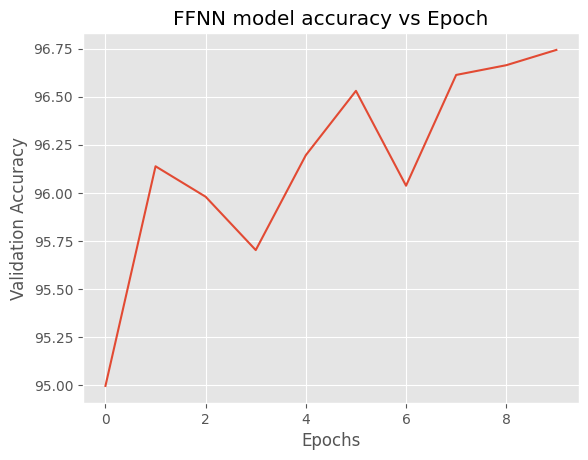

In [65]:
# accs = [value * 100 for value in accs]
# accs = [value/100 for value in accs]
plt.plot(range(len(accs)), accs)
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("FFNN model accuracy vs Epoch")
plt.show()

In [66]:
accuracy_score(true_val_labels, predicted_val_labels)*100

97.04004817825957

In [67]:
print(classification_report(true_val_labels, predicted_val_labels))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      6530
           1       0.96      0.85      0.90      2270
           2       0.99      0.95      0.97      5680
           3       0.98      0.99      0.98     14150
           4       0.98      0.99      0.98      4140
           5       0.99      0.99      0.99      1070
           6       0.93      0.92      0.93      1310
           7       0.94      0.98      0.96       350
           8       0.77      0.71      0.74       590
           9       0.98      0.95      0.97      2660
          10       0.98      0.99      0.98     15510
          11       0.96      0.98      0.97     11430
          12       0.91      0.86      0.89       730

    accuracy                           0.97     66420
   macro avg       0.95      0.93      0.94     66420
weighted avg       0.97      0.97      0.97     66420



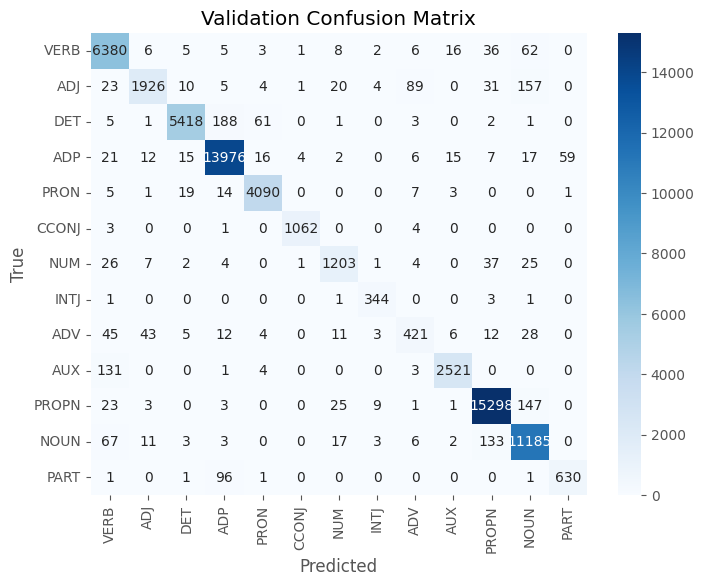

In [68]:
conf_matrix = confusion_matrix(true_val_labels, predicted_val_labels)
class_labels = list(tag_map.keys())
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Validation Confusion Matrix')
plt.show()

In [69]:
#--------------TEST-------------
true_labels = []
predicted_labels = []

model.eval()
total_val_correct = 0
total_val_samples = 0

with torch.no_grad():
  for i, (test_sent, test_label) in enumerate(test_loader):
        num_arr = test_sent.numpy()
        input_embed = []
        for arr in num_arr:
          embeds = []
          # print("array: ", arr)
          for num in arr:
            word = num_to_word[num]
            # print('word: ', word)
            # if word not in glove_vectors.key_to_index:
                # print(f"{word} not in glove")
            embed = glove_vectors[word] if word in glove_vectors.key_to_index else np.random.uniform(-1.0,1.0,size = (300,))
            # if word == '<s>':
            #   embed = [-1.0]*300
            # elif word == '</s>':
            #   embed = [1.0]*300

            arr = embed.copy()

            # embed /= np.linalg.norm(arr)
            embeds.append(embed)
          embeddings = np.array([item for sublist in embeds for item in sublist])
          # print("sub size: ",embeddings.shape)
          input_embed.append(embeddings)

        input_embed = np.array(input_embed, dtype = np.double)
        input_embed = torch.tensor(input_embed, dtype=torch.double)
        input_embed = input_embed.to(device, dtype=torch.double)
        test_label = test_label.to(device)

        outputs = model(input_embed)
        test_loss = loss_fn(outputs, test_label)
        _, predicted = torch.max(outputs.data, 1)
        total_val_samples += test_label.size(0)
        total_val_correct += (predicted == test_label).sum().item()
        true_labels.extend(test_label.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

In [70]:
accuracy_score(true_labels, predicted_labels)*100

97.64437689969606

In [71]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.99      0.94      0.97       629
           1       0.90      0.95      0.93       220
           2       0.99      0.99      0.99       512
           3       0.99      0.99      0.99      1434
           4       0.98      0.98      0.98       392
           5       0.99      0.99      0.99       109
           6       0.92      0.88      0.90       127
           7       0.92      0.97      0.95        36
           8       0.83      0.58      0.68        76
           9       0.98      0.99      0.98       256
          10       0.99      0.99      0.99      1567
          11       0.96      0.99      0.97      1166
          12       0.97      1.00      0.98        56

    accuracy                           0.98      6580
   macro avg       0.95      0.94      0.95      6580
weighted avg       0.98      0.98      0.98      6580



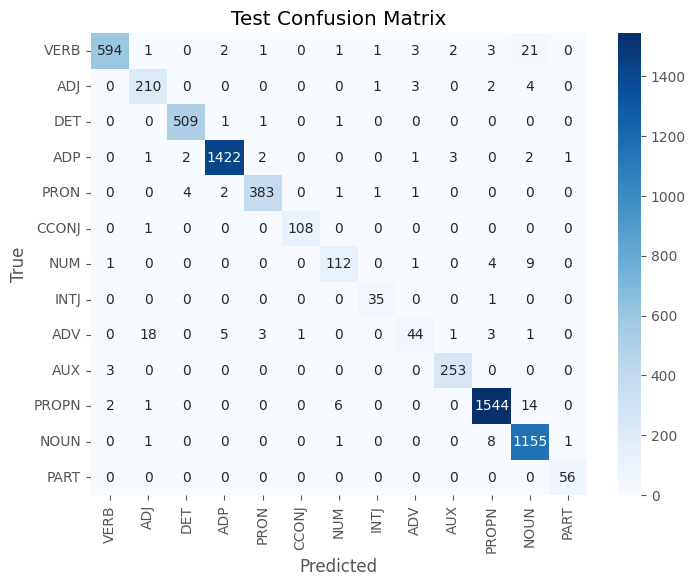

In [72]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
class_labels = list(tag_map.keys())
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

In [73]:
import os
os.chdir("/content/drive/MyDrive/INLP/Assignment - 2")
os.getcwd()

'/content/drive/MyDrive/INLP/Assignment - 2'

In [74]:
torch.save(model, "ffnn_model3_ps3.pt")